In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from pathlib import Path 
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from tqdm.notebook import tqdm
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
# check the labels dataframe
labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [3]:
# drop the duplicates (if any)
labels = labels.drop_duplicates('patientId')

In [4]:
#defne paths
root_path=Path('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/')
save_path = Path('processed')

Let's explore some images

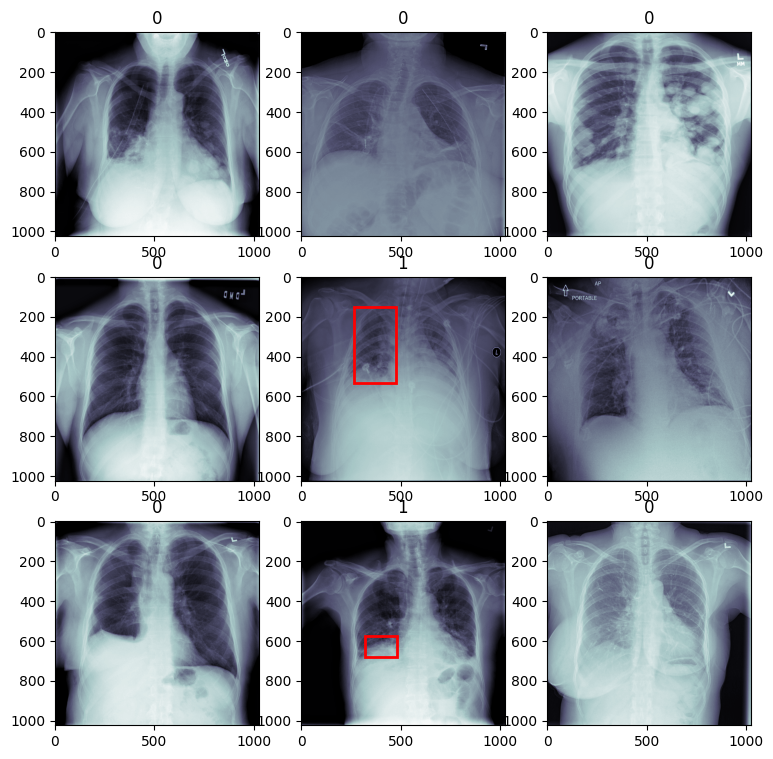

In [5]:
fig,axs = plt.subplots(3,3, figsize=(9,9))
c=0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        ax= axs[i,j]
        dcm_path = root_path/patient_id
        dcm_data = dcm_path.with_suffix('.dcm')
        #dcm_path = os.path.join(root_path,f'{patient_id}.dcm')
        image = pydicom.dcmread(dcm_data).pixel_array
# Bounding box for the infected portion
        boxes = labels[labels['patientId']==patient_id]
        for _,row in boxes.iterrows():
            if not pd.isna(row['x']):
                rect = Rectangle((row['x'], row['y']),row['width'],row['height'], linewidth=2, edgecolor='r',facecolor='none')
                ax.add_patch(rect)
        label = labels['Target'].iloc[c]
        ax.imshow(image,cmap = 'bone')
        ax.set_title(label)
        #ax.axis('off')
        c+=1

The rectangles in the images that are labeled '1' , specify the infected regions 

In [6]:
sums,sums_squared = 0,0
for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = root_path/patient_id
    dcm_data = dcm_path.with_suffix('.dcm')
    dcm = pydicom.dcmread(dcm_data).pixel_array/255
    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)

    label = labels.Target.iloc[c]

    train_or_val = 'train' if c<24000  else 'val'

    current_save_path = save_path/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id,dcm_array)

    normalizer = 224*224
    if train_or_val == 'train':
        sums += np.sum(dcm_array)/normalizer
        sums_squared += (dcm_array**2).sum()/normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [7]:
mean = sums/24000
std = np.sqrt((sums_squared/24000)-mean**2)
print(mean,std)

0.4903962485384803 0.24795070634161256


In [8]:
def file_loader(path):
    return np.load(path).astype(np.float32)

In [9]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean, std),
                                       transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9, 1.1)),
                                       transforms.RandomResizedCrop((224,224), scale=(0.35,1))
                                      ])
val_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean,std)
                                    ])

In [10]:
train_dataset = torchvision.datasets.DatasetFolder('processed/train/',loader=file_loader,extensions='npy',transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder('processed/val/',loader=file_loader,extensions='npy',transform=val_transforms)

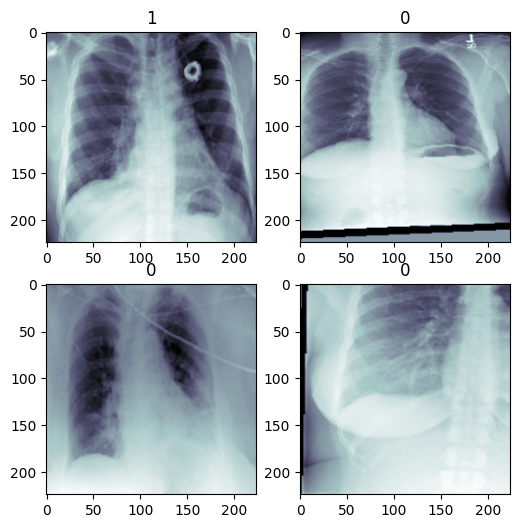

In [11]:
fig,axis=plt.subplots(2,2,figsize=(6,6))
for i in  range(2):
    for j in range(2):
        ax=axis[i,j]
        random_index = np.random.randint(0,24000)
        img,label = train_dataset[random_index]
        ax.imshow(img[0], cmap='bone')
        ax.set_title(label)

In [12]:
batch_size = 64
num_workers = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers,shuffle=False)

In [40]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [14]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super(PneumoniaModel,self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        #modify input layer for grayscale images set output features to1 for binary classification
        self.model.conv1 = torch.nn.Conv2d(1,64,kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        self.loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')        

    def forward(self,data):
        pred = self.model(data)
        return pred

    def training_step(self,batch,batch_index):
        img,label = batch
        label = label.float()
        pred = self(img)[:,0]
        loss = self.loss_func(pred,label)

        self.log('Train Loss',loss)
        self.log('Step Train ACC', self.train_acc(torch.sigmoid(pred),label.int()))
        return loss

    def on_train_epoch_end(self):
        self.log('Train ACC', self.train_acc.compute())
        self.train_acc.reset()

    def validation_step(self,batch,batch_index):
        img,label = batch
        label = label.float()
        pred = self(img)[:,0]
        loss = self.loss_func(pred,label)

        self.log('Val Loss',loss)
        self.log('Step Val ACC', self.train_acc(torch.sigmoid(pred),label.int()))

    def on_validation_epoch_end(self):
        self.log('Val ACC', self.val_acc.compute())
        self.val_acc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(),lr=0.0001)
        return optimizer
        

In [64]:
model = PneumoniaModel()

In [65]:
checkpoint_callback = ModelCheckpoint(monitor='Val ACC',
                                      save_top_k=10,
                                      mode='max')

In [66]:
tainer = pl.Trainer(devices=1,accelerator='gpu',logger=TensorBoardLogger(save_dir='./logs'), log_every_n_steps=1, callbacks=checkpoint_callback,max_epochs=35)

In [67]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [71]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = PneumoniaModel.load_from_checkpoint('/kaggle/working/logs/lightning_logs/version_0/checkpoints/weights_3.ckpt')
#model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [72]:
preds = []
labels = []
with torch.no_grad():
    for data,label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [78]:
# Confusion matrix
acc = torchmetrics.Accuracy(task='binary')(preds,labels)
precision = torchmetrics.Precision(task='binary')(preds,labels)
recall = torchmetrics.Recall(task='binary')(preds,labels)
cm = torchmetrics.ConfusionMatrix(task='binary',num_classes=2)(preds,labels)

print(f'Accuracy {acc}')
print(f'Precision {precision}')
print(f'Recall {recall}')
print(f'Confusion Matrix {cm}')

Accuracy 0.7745901346206665
Precision 0.0
Recall 0.0
Confusion Matrix tensor([[2079,    0],
        [ 605,    0]])


In [79]:
import tensorflow as tf
import glob

In [90]:
# Load data from the TensorBoard log files
event_files = glob.glob('./logs/lightning_logs/version_0/checkpoints//kaggle/working/logs/lightning_logs/version_0/events.out.tfevents.1730053729.98e44fa8a2b7.30.2')
data = pd.DataFrame()

for file in event_files:
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.tag in ['Train Loss', 'Val Loss', 'Train ACC', 'Val ACC']:
                data = pd.concat([data, pd.DataFrame({
                    'step': [e.step],
                    'metric': [v.tag],
                    'value': [v.simple_value]
                })])

In [91]:
print(data.head())

Empty DataFrame
Columns: []
Index: []


In [92]:
# Plot metrics
plt.figure(figsize=(10, 5))
for metric in data['metric'].unique():
    metric_data = data[data['metric'] == metric]
    plt.plot(metric_data['step'], metric_data['value'], label=metric)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

KeyError: 'metric'

<Figure size 1000x500 with 0 Axes>